# Tecnológico de Monterrey
## Maestría en Inteligencia Artificial Aplicada
---

### **Materia:** Proyecto Integrador

---

### **Avance 1:** Análisis exploratorio de datos

---

### **Proyecto:** Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación

---

### **Profesora:** Dra. Grettel Barceló Alonso
### **Asesor:** Dr. Horacio Martínez Alfaro

---
### **Equipo 42 - Autorización individual**
### A00841954 Christian Erick Mercado Flores

---

Fecha: 28 de Septiembre de 2025

### **Descripción del Proyecto**

En el marco del desarrollo de la materia de Proyecto Integrador, el presente trabajo propone el desarrollo del proyecto que lleva por título: **Chatbot jurídico para soporte informativo en el análisis de carpetas de investigación.**

La institución con la cual se colaborará y donde se implementará el proyecto es la **Fiscalía Especializada en Combate a la Corrupción del Estado de Michoacán**, también conocida como la **Fiscalía Anticorrupción de Michoacán**.

Específicamente, el área dentro de la institución donde se pondrá en marcha el trabajo es la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares**.

### **Objetivo del Proyecto**

Poner a disposición de los agentes de la **Unidad de Delitos Cometidos por Servidores Públicos y Particulares** de la **Fiscalía Anticorrupción de Michoacán**, un **chatbot conversacional** que pueda proveer **soporte informativo** a partir del **marco jurídico aplicable** y de **carpetas de investigación** centralizados en un sistema de archivos.

### **Descripción del trabajo**

El Presente trabajo realiza un **Preprocesamiento* de los datos de texto de los documentos a utilizar en los modelos del sistema propuesto, así como la aplicación de un **EDA** y la redacción de conclusiones de dicho análisis.

# Índice

#### 1. Librarías y Constantes

#### 2. Procesamiento de Archivos

#### 3. Preprocesamiento Texto y Metadatos

#### 4. Análisis Exploratorio de Datos (EDA)
	* 4.1. Estructura de los datos
	* 4.2. Análisis univariante
		* a) Histogramas
		* b) Análisis de distribución
		* c) Análisis de valores atípicos
		* d) Boxplots
	* 4.3. Análisis bivariante
		* a) Scatter plots
		* b) Correlaciones

#### 5. Conclusiones

#### 6. Referencias

# 1. Librarías y Constantes

In [1]:
pip install -q pandas numpy matplotlib seaborn tqdm tika pdfplumber python-docx pillow spacy python-magic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 49.6 MB/s eta 0:00:00


In [2]:
# Importación de Librearías

# 1) Librerías Estándar de Python (Built-in)
import os
import re
import math
import mimetypes
import unicodedata
from datetime import datetime
from pathlib import Path

# 2) Librerías de Terceros (Alfabético)
import magic
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pdfplumber
import seaborn as sns
from docx import Document
from scipy import stats
from scipy.stats import skew, kurtosis
from tika import parser as tika_parser
from tqdm import tqdm

# 3) Librerías de Procesamiento de Lenguaje Natural (NLP)
import nltk
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# 4) Configuración/Descargas (Ejecutar solo una vez)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
# Configuración de Constantes

# 1) Definición de la carpeta base
BASE_DIR = Path("./file-system")

# 2) Definición de subcarpetas específicas
CARPETAS_DIR = BASE_DIR / "CARPETAS"
MARCO_LEGAL_DIR = BASE_DIR / "MARCO-LEGAL"

# 3) Configuración del conjunto de stopwords en español
SPANISH_STOP = set(stopwords.words('spanish')) if 'spanish' in stopwords.fileids() else set()

# 2. Procesamiento de Archivos

En esta sección se procedió a la **conformación de un corpus de textos** que representan los datos con lo cuales el proyecto "Chatbot jurídico para soporte informativo en el análisis de Carpetas de Investigación" va a trabajar. Este corpus está integrado por los siguientes tipos de documentos:
  - Documentos legales (**Marco Jurídico**): contienen textos que están divididos estructuralmente siguiendo una lógica jurídica (como capítulos, secciones, artículos, etc.). Provienen de instituciones, entidades y fuentes legales (como Código Penal para el Estado de Michoacán, Ley Orgánica de la Fiscalía General del Estado de Michoacán, etc.).

  - Documentos de **Carpetas de Investigación**: tienen textos escritos siguiendo una narrativa legal o jurídica, o siguiendo formatos administrativo-legales. Se generan dentro de la propia Unidad de la Fiscalía con la que se trabaja en el proyecto.

In [4]:
def process_files(base_path):
    """
    Recorre recursivamente los archivos dentro de un directorio base y construye
    un DataFrame con metadatos de cada archivo encontrado.

    Parámetros:
        base_path (Path) : Objeto Path que indica el directorio base a recorrer.

    Retorno:
        pd.DataFrame : DataFrame que contiene una fila por archivo con las siguientes
                       columnas:
                       - "path"       (str)  : Ruta completa del archivo.
                       - "name"       (str)  : Nombre base del archivo sin extensión.
                       - "size_bytes" (int)  : Tamaño del archivo en bytes.
                       - "mime"       (str)  : Tipo MIME detectado o estimado del archivo.
    """

    # 1) Inicialización de estructura para almacenar resultados
    rows = []  # Lista donde se guardarán los metadatos de cada archivo

    # 2) Recorrido recursivo de todos los elementos en el directorio base
    for p in base_path.rglob("*"):  # Itera sobre todos los archivos y carpetas
        if p.is_file():             # Solo procesa si es archivo

            # 3) Obtención de metadatos básicos del archivo
            stat = p.stat() # Se obtiene información del sistema sobre el archivo
            mime = None     # Inicializa el valor MIME como None

            # 4) Intento de detección precisa del tipo MIME
            try:
                mime = magic.from_file(str(p), mime=True)  # Detecta MIME con librería 'magic'
            except Exception:
                mime = mimetypes.guess_type(p)[0]  # Estima MIME como fallback usando 'mimetypes'

            # 5) Almacenamiento de resultados en la lista de filas
            rows.append({
                "path": str(p),             # Ruta completa del archivo
                "name": p.stem,             # Nombre del archivo sin extensión
                "size_bytes": stat.st_size, # Tamaño en bytes
                "mime": mime,               # Tipo MIME detectado o estimado
            })

    # 6) Conversión de resultados a DataFrame
    return pd.DataFrame(rows)  # Retorna la estructura tabular con metadatos

In [5]:
# Procesamiento de archivos y muestra de estadísticas

# 1) Obtención de DataFrames con los archivos procesados
carpetas_df = process_files(CARPETAS_DIR)
marco_juridico_df = process_files(MARCO_LEGAL_DIR)

# 2) Impresión de resultados de conteo de archivos procesados
print(f"=== Archivos Procesados ==")
print(f"Archivos de Carpetas de Investigación: {len(carpetas_df)}")
print(f"Archivos de Marco Jurídico: {len(marco_juridico_df)}")

=== Archivos Procesados ==
Archivos de Carpetas de Investigación: 32
Archivos de Marco Jurídico: 24


In [6]:
# Vista previa de los primeros registros
carpetas_df.head()

,path,name,size_bytes,mime
0,file-system/CARPETAS/2025-MICH-FECC-0001789/3-...,oficio_de_instruccion_del_ministerio_publico,69721,application/pdf
1,file-system/CARPETAS/2025-MICH-FECC-0001789/3-...,acuerdo_de_designacion_de_investigador_a_cargo,67710,application/pdf
2,file-system/CARPETAS/2025-MICH-FECC-0001789/1-...,hoja_de_identificacion_del_denunciante,67041,application/pdf
3,file-system/CARPETAS/2025-MICH-FECC-0001789/1-...,lista_de_anexos,89838,application/pdf
4,file-system/CARPETAS/2025-MICH-FECC-0001789/1-...,denuncia_por_hecho_delictivo,69067,application/pdf


In [7]:
# Información general del DataFrame
carpetas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        32 non-null     object
 1   name        32 non-null     object
 2   size_bytes  32 non-null     int64 
 3   mime        32 non-null     object
dtypes: int64(1), object(3)
memory usage: 1.1+ KB


In [8]:
# Vista previa de los primeros registros
marco_juridico_df.head()

,path,name,size_bytes,mime
0,file-system/MARCO-LEGAL/TIPO-DELITO/reglamento...,reglamento_de_la_ley_organica_de_la_fiscalia_g...,1382808,application/pdf
1,file-system/MARCO-LEGAL/TIPO-DELITO/ley_organi...,ley_organica_de_la_fiscalia_general_del_estado...,616234,application/pdf
2,file-system/MARCO-LEGAL/TIPO-DELITO/codigo_pen...,codigo_penal_para_el_estado_de_michoacan,1940655,application/pdf
3,file-system/MARCO-LEGAL/PROCESO-PENAL/jurispru...,jurisprudencia_corrupcion,2093797,application/pdf
4,file-system/MARCO-LEGAL/PROCESO-PENAL/corte_in...,corte_interamericana_de_derechos_humanos_caso_...,874967,application/pdf


In [9]:
# Información general del DataFrame
marco_juridico_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   path        24 non-null     object
 1   name        24 non-null     object
 2   size_bytes  24 non-null     int64 
 3   mime        24 non-null     object
dtypes: int64(1), object(3)
memory usage: 900.0+ bytes


# 3. Preprocesamiento Texto y Metadatos

En esta sección se procedió con el **preprocesamiento** de los datos de los textos. Este proceso es sustancialmente diferente al preprocesamiento de los tipos de datos numéricos o categóricos. Pues, el procesar los textos no se trata de una tarea de buscar valores atípicos, faltantes o imputar cifras, sino que la tarea en realidad es preservar tanto la estructura lógica e integridad semántica de los textos (Ferraris et al., 2024), toda vez que son procesados para que los modelos de *Machine Learning* puedan utilizarlos. Para esta tarea de preprocesamiento se utilizaron técnicas de Procesamiento de Lenguaje Natural o *Natural Language Processing* (*NLP*). Específicamente se aplicaron técnicas de *Chunking* (dividir fragmentos de texto o *tokens* en segmentos) y *Tokenización* (dividir el texto en unidades más pequeñas como palabras, subpalabras o caracteres) (Vaj, 2024).

  - Para Documentos legales (**Marco Jurídico**) se utilizó:
    * ***Tokenización***: se aplicó un proceso de *Tokenización* más fuerte, pues estos documentos no presentan una estructura rígida como la de artículos, sino que presenta textos más narrativos. En este sentido se aplicó un proceso de limpieza del corpus aplicando normalizando Unicode, convirtiendo a minúsculas, filtrando palabras cortas o no alfabéticas y eliminando stopwords en español, con el objetivo de tener *tokens* que representaran patrones clave.
    * ***Chunking***: se siguió la técnica desarrollada por el artículo '*No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts*' (Fama et al., 2024). Este artículo procesa textos legales y mostró buenos resultados en su procesamiento de *chunks*. Este a grandes rasgos hace un *overlap* especial que mantiene el contexto de *chunks* pasados en nuevos, evitando la perdida de contexto en textos muy largos.
    
  - Documentos de **Carpetas de Investigación** se utilizó:
    * ***Tokenización***: estos textos son más rígidos, presentando estructuras por artículos, párrafos, etc. De esta manera, se procedió con una limpieza de texto más simple para que el contexto del contenido no se perdiera, conservando así saltos de línea, divisiones entre párrafos y preservando números y puntuación.
    * ***Chunking***: para esta sección se aplicó un proceso de *Chunking* estructural con un *overlap* mínimo entre segmentos, con el objetivo de preservar artículos completos en los *chunks* y no perder el contexto de estos artículos. Por tal motivo, se aplicaron expresiones regulares para identificar y preservar estas secciones.

In [10]:
def extract_text_pdf(path):
    """
    Extrae el contenido textual de un archivo PDF.

    Parámetros:
        path (str) : Ruta al archivo PDF a procesar.

    Retorno:
        str : Texto completo extraído del PDF. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Inicialización de lista para almacenar texto de cada página
        texts = []

        # 3) Apertura del PDF y extracción de texto por página
        with pdfplumber.open(path) as pdf:
            for page in pdf.pages:
                texts.append(page.extract_text() or "")  # Extrae texto o agrega cadena vacía

        # 4) Unión de todos los textos en un solo string
        return "\n".join(texts)

    # 5) Retorno en caso de error durante la extracción
    except Exception as e:
        return ""

In [11]:
def extract_text_docx(path):
    """
    Extrae el contenido textual de un archivo DOCX.

    Parámetros:
        path (str) : Ruta al archivo DOCX a procesar.

    Retorno:
        str : Texto completo extraído del DOCX. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Apertura del documento DOCX
        doc = Document(path)

        # 3) Extracción del texto de cada párrafo
        parts = [p.text for p in doc.paragraphs]

        # 4) Unión de todos los textos en un solo string
        return "\n".join(parts)

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [12]:
def extract_text_tika(path):
    """
    Extrae el contenido textual de un archivo usando Apache Tika.

    Parámetros:
        path : Ruta al archivo a procesar con Tika.

    Retorno:
        str : Texto completo extraído del archivo. Si ocurre un error, retorna cadena vacía.
    """

    # 1) Manejo de errores generales
    try:

        # 2) Parseo del archivo usando Tika
        parsed = tika_parser.from_file(path)
        content = parsed.get('content') or parsed.get('text') or ""  # Obtiene contenido principal

        # 3) Decodificación si el contenido está en bytes
        if isinstance(content, bytes):
            try:
                content = content.decode('utf-8', errors='ignore')
            except Exception:
                content = str(content)  # Fallback a string estándar si falla decodificación

        # 4) Retorno del contenido extraído
        return content or ""

    # 5) Retorno en caso de error durante la extracción
    except Exception:
        return ""

In [13]:
def extract_text(path):
    """
    Extrae el texto de un archivo aplicando primero métodos específicos por tipo
    de archivo y, si fallan, utiliza Tika como fallback.

    Parámetros:
        path (str) : Ruta al archivo a procesar.

    Retorno:
        str : Texto completo extraído del archivo, limpio de espacios iniciales y finales.
    """

    # 1) Determinar la extensión del archivo
    ext = Path(path).suffix.lower()
    text = ""

    # 2) Procesamiento de PDFs
    if ext == '.pdf':
        text = extract_text_pdf(path)  # Intento preferido con pdfplumber
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 3) Procesamiento de archivos Word
    elif ext in ['.docx', '.doc']:
        text = extract_text_docx(path)  # Intento preferido con python-docx
        if not text:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 4) Procesamiento de archivos de texto plano o Markdown
    elif ext in ['.txt', '.md']:
        try:
            with open(path, 'r', encoding='utf-8', errors='ignore') as f:
                text = f.read()  # Lectura directa de archivo
        except Exception:
            text = extract_text_tika(path)  # Fallback a Tika si falla

    # 5) Otros tipos de archivo
    else:
        text = extract_text_tika(path)  # Uso directo de Tika

    # 6) Retorno del texto limpio
    return (text or "").strip()

In [14]:
def generate_tokens_legal_structures(text):
    """
    Genera tokens a partir de un texto dado, preservando números, puntuación y estructura
    para textos legales, con normalización Unicode y conversión a minúsculas.

    Parámetros:
        text (str) : Texto de entrada a tokenizar.

    Retorno:
        list : Lista de tokens que incluye palabras, números y puntuación relevante.
    """
    if not text:
        return []

    # 1) Normalización Unicode
    text = unicodedata.normalize('NFKC', text)

    # 2) Tokenización preservando números y puntuación
    tokens = word_tokenize(text.lower())  # Convierte a minúsculas, pero no filtra aún

    # 3) Filtra solo tokens vacíos o irrelevantes, manteniendo números y puntuación
    tokens = [t for t in tokens if t.strip() and t not in SPANISH_STOP]

    return tokens

In [15]:
def generate_tokens_legal_texts(text):
    """
    Genera tokens limpios a partir de un texto dado, normalizando Unicode,
    convirtiendo a minúsculas, filtrando palabras cortas o no alfabéticas y
    eliminando stopwords en español.

    Parámetros:
        text (str) : Texto de entrada a tokenizar.

    Retorno:
        list : Lista de tokens limpios y filtrados.
    """

    # 1) Verificación de texto vacío
    if not text:
        return []

    # 2) Normalización Unicode del texto
    text = unicodedata.normalize('NFKC', text)

    # 3) Tokenización y filtrado inicial
    tokens = [t.lower() for t in word_tokenize(text) if t.isalpha() and len(t)>1]

    # 4) Eliminación de stopwords en español
    tokens = [t for t in tokens if t not in SPANISH_STOP]

    # 5) Retorno de tokens procesados
    return tokens

In [16]:
def chunk_legal_structures(tokens, overlap_percent=0.1):
    """
    Segmenta tokens de texto legal en bloques basados en encabezados y estructuras legales,
    permitiendo un solapamiento opcional entre bloques.

    Parámetros:
        tokens (list)        : Lista de tokens del texto legal.
        overlap_percent (float) : Porcentaje de solapamiento entre bloques (0 a 1).

    Retorno:
        list : Lista de chunks, donde cada chunk es una lista de tokens.
    """

    # 1) Reconstrucción del texto a partir de tokens
    text = ' '.join(tokens)

    # 2) Definición de patrones para dividir el texto
    split_patterns = [
        r'Artículo \d+[A-Za-z]*',   # Captura "Artículo 35", "Artículo Primero", "Artículo 35 Bis"
        r'Art\. \d+[A-Za-z]*',      # Captura "Art. 35", "Art. 35-A"
        r'^\d+\.\s*',               # Captura "7. ", "8. " al inicio de línea
        r'Justificación:?\s*',      # Captura "Justificación:" o "Justificación"
        r'Criterio jurídico:?\s*',  # Captura "Criterio jurídico:" o "Criterio jurídico"
        r'Hechos:?\s*',             # Captura "Hechos:" o "Hechos"
    ]
    combined_pattern = r'(?i)(' + '|'.join(split_patterns) + ')'  # Corrected: move (?i) outside the group

    # 3) División del texto usando los patrones
    splits = re.split(combined_pattern, text)
    splits = [s.strip() for s in splits if s.strip()]

    # 4) Inicialización de variables para construcción de chunks
    chunks = []
    current_chunk = []

    # 5) Iteración sobre cada fragmento dividido
    for part in splits:
        if re.match(combined_pattern, part):  # Encabezado detectado
            if current_chunk:
                overlap_tokens = int(len(current_chunk) * overlap_percent)
                chunks.append(current_chunk.copy())  # Guardar chunk actual
                if overlap_tokens > 0:
                    current_chunk = current_chunk[-overlap_tokens:]  # Mantener solapamiento
                else:
                    current_chunk = []
            current_chunk.extend(part.split())  # Agregar tokens del encabezado
        else:
            current_chunk.extend(part.split())  # Agregar tokens del contenido

    # 6) Guardar el último chunk si existe
    if current_chunk:
        chunks.append(current_chunk.copy())

    # 7) Retorno de todos los chunks generados
    return chunks

In [17]:
def chunk_legal_texts(tokens, max_chunk_tokens=512, overlap_percent=0.1):
    """
    Divide un texto en chunks de tamaño máximo con solapamiento, siguiendo la metodología
    de 'No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts'.

    Parámetros:
        tokens (list)        : Lista de tokens del texto legal.
        max_chunk_tokens (int) : Número máximo de tokens por chunk.
        overlap_percent (float) : Porcentaje de solapamiento entre chunks.

    Retorno:
        list : Lista de chunks, donde cada chunk es una lista de tokens.
    """

    # 1) Retorno inmediato si la lista de tokens está vacía
    if not tokens:
        return []

    # 2) Inicialización de variables
    chunks = []
    total_tokens = len(tokens)

    # 3) Cálculo del número de tokens de solapamiento
    overlap_tokens = int(max_chunk_tokens * overlap_percent)
    z_half = overlap_tokens // 2  # Se usa la mitad para avanzar en cada iteración

    # 4) Iteración para generar los chunks
    start = 0
    while start < total_tokens:
        end = start + max_chunk_tokens
        chunk = tokens[start:end]  # Selección de los tokens del chunk actual
        chunks.append(chunk)
        start = start + max_chunk_tokens - z_half  # Avance considerando solapamiento

    # 5) Retorno de todos los chunks generados
    return chunks

In [18]:
def process_text(files_df, are_legal_structures=False):
    """
    Procesa archivos listados en un DataFrame, extrayendo texto, calculando métricas
    básicas de longitud, generando tokens limpios y dividiendo el texto en chunks.

    Parámetros:
        files_df (pd.DataFrame) : DataFrame con al menos las columnas 'path', 'name' y 'size_bytes'.
        are_legal_structures (bool) : Si True, usa chunking basado en estructura legal;
                                      si False, usa chunking estándar por tamaño.

    Retorno:
        pd.DataFrame : DataFrame con métricas por archivo, incluyendo longitud de texto,
                       tokens y número de chunks.
    """

    # 1) Inicialización de lista para almacenar resultados por archivo
    records = []

    # 2) Iteración sobre cada archivo del DataFrame con barra de progreso
    for idx, row in tqdm(files_df.iterrows(), total=len(files_df)):

        # 2a) Extracción del texto del archivo
        path = row['path']
        text = extract_text(path)
        text_len = len(text)
        n_raw_tokens = len(text.split())

        # 2b) Cálculo de largo promedio de palabras
        mean_word_len = np.mean([len(word) for word in text.split()])

        # 2c) Cálculo de largo promedio de oraciones
        mean_sent_length = np.mean([len(sent) for sent in tokenize.sent_tokenize(text)])

        # 2d) Generación de tokens limpios y chunks según tipo de chunking
        if are_legal_structures:
            clean_tokens = generate_tokens_legal_structures(text)
            chunks = chunk_legal_structures(clean_tokens)
        else:
            clean_tokens = generate_tokens_legal_texts(text)
            chunks = chunk_legal_texts(clean_tokens)

        # 2f) Conteo de tokens limpios y número de chunks
        n_clean_tokens = len(clean_tokens)
        n_chunks = len(chunks)

        # 2e) Almacenamiento de métricas en la lista de resultados
        records.append({
            'name': row['name'],
            'size_bytes': row['size_bytes'],
            'text_len': text_len,
            'mean_word_len': mean_word_len,
            'mean_sent_len': mean_sent_length,
            'n_raw_tokens': n_raw_tokens,
            'n_clean_tokens': n_clean_tokens,
            'n_chunks': n_chunks,
        })

    # 3) Conversión de resultados a DataFrame y retorno
    return pd.DataFrame(records)

In [19]:
# Procesamiento de metadatos de archivos de carpetas y vista previa

# 1) Generación de DataFrame con metadatos de archivos
carpetas_meta_df = process_text(carpetas_df, False)

# 2) Mostrar los primeros registros del DataFrame resultante
carpetas_meta_df.head()

100%|██████████| 32/32 [00:06<00:00,  5.09it/s]


,name,size_bytes,text_len,mean_word_len,mean_sent_len,n_raw_tokens,n_clean_tokens,n_chunks
0,oficio_de_instruccion_del_ministerio_publico,69721,1869,5.726619,132.571429,278,143,1
1,acuerdo_de_designacion_de_investigador_a_cargo,67710,1669,5.872428,166.000000,243,137,1
2,hoja_de_identificacion_del_denunciante,67041,1065,5.877419,49.809524,155,84,1
3,lista_de_anexos,89838,3515,5.323741,53.092308,556,287,1
4,denuncia_por_hecho_delictivo,69067,1783,5.607407,147.666667,270,149,1


In [20]:
# Información general del DataFrame
carpetas_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            32 non-null     object 
 1   size_bytes      32 non-null     int64  
 2   text_len        32 non-null     int64  
 3   mean_word_len   32 non-null     float64
 4   mean_sent_len   32 non-null     float64
 5   n_raw_tokens    32 non-null     int64  
 6   n_clean_tokens  32 non-null     int64  
 7   n_chunks        32 non-null     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 2.1+ KB


In [21]:
# Procesamiento de metadatos de archivos de marco jurídico y vista previa

# 1) Generación de DataFrame con metadatos de archivos
marco_juridico_meta_df = process_text(marco_juridico_df, True)

# 2) Mostrar los primeros registros del DataFrame resultante
marco_juridico_meta_df.head()

100%|██████████| 24/24 [07:12<00:00, 18.02s/it]


,name,size_bytes,text_len,mean_word_len,mean_sent_len,n_raw_tokens,n_clean_tokens,n_chunks
0,reglamento_de_la_ley_organica_de_la_fiscalia_g...,1382808,270786,5.550376,150.109933,41339,27334,210
1,ley_organica_de_la_fiscalia_general_del_estado...,616234,87029,5.624296,174.818182,13138,8853,92
2,codigo_penal_para_el_estado_de_michoacan,1940655,279654,5.094162,146.965608,45889,30290,423
3,jurisprudencia_corrupcion,2093797,98681,5.496083,182.096475,15191,10567,139
4,corte_interamericana_de_derechos_humanos_caso_...,874967,434647,5.282947,127.101975,69179,52594,327


In [22]:
# Información general del DataFrame
marco_juridico_meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            24 non-null     object 
 1   size_bytes      24 non-null     int64  
 2   text_len        24 non-null     int64  
 3   mean_word_len   24 non-null     float64
 4   mean_sent_len   24 non-null     float64
 5   n_raw_tokens    24 non-null     int64  
 6   n_clean_tokens  24 non-null     int64  
 7   n_chunks        24 non-null     int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.6+ KB


# 4. Análisis Exploratorio de Datos (EDA)

En esta sección se realizó un Análisis Exploratorio de Datos o *Exploratory Data Analysis* (*EDA*). Este análisis permite desentrañar la naturaleza intrínseca de los datos, caracterizar sus principales atributos y descubrir las interrelaciones entre variables (Ministerio de Asuntos Económicos y Transformación Digital, 2024). Existen métodos de *EDA* específicos que funcionan para problemas de *NLP* (como es el caso de este proyecto) y que conducen a un resultado productivo. Para esto normalmente se utilizan recuentos de palabras y oraciones, su longitud y longitud promedio (Singh, 2022). En este trabajo se utilizaron las siguientes métricas:
  - `size_bytes`: tamaño físico del archivo en bytes.
  - `text_len`: longitud total del texto extraído del documento, medida en número de caracteres.
  - `mean_word_len`: largo promedio de las palabras en el documento, medida en caracteres.
  - `mean_sent_len`: largo promedio de las oraciones en el documento, medida en caracteres.
  - `n_raw_tokens`: número total de tokens crudos que resultan de una división simple del texto por espacios.
  - `n_clean_tokens`: número total de tokens limpios después de aplicar el proceso de *Tokenización* correspondiente.
  - `n_chunks`: número total de *chunks* en los que se dividió el texto después de aplicar el proceso de *Chunking* correspondiente.

A continuación se presentan los siguientes análisis dentro del contexto del *EDA*:
  * Estructura de los datos

  * Análisis univariante
    * Histogramas
    * Análisis de distribución
    * Análisis de valores atípicos
    * Boxplots
    
  * Análisis bivariante
    * Scatter plots
    * Correlaciones

## 4.1. Estructura de los datos

In [23]:
def show_stats(meta_df: pd.DataFrame):
    """
    Muestra un resumen estadístico y descriptivo de un DataFrame de metadatos de archivos.

    Parámetros:
        meta_df (pd.DataFrame) : DataFrame que contiene información de archivos, incluyendo la columna 'name'.

    Retorno:
        None : La función imprime resultados directamente y no retorna valor.
    """

    # 1) Copia del DataFrame sin la columna 'name' para análisis
    meta_copy_df = meta_df.drop(columns=['name']).copy()

    # 2) Mostrar forma del DataFrame
    print('\n=== Forma (Filas, Columnas) ===')
    print(meta_copy_df.shape)

    # 3) Mostrar tipos de datos de cada columna
    print('\n=== Tipos de Datos ===')
    display(meta_copy_df.dtypes)

    # 4) Mostrar estadísticas descriptivas para todas las columnas
    print('\n=== Estadísticas Descriptivas ===')
    display(meta_copy_df.describe(include='all').T)

    # 5) Análisis de frecuencia de combinaciones de columnas
    print('\n=== Análisis de Frecuencia ===')
    display(meta_copy_df.value_counts(dropna=False))

    # 6) Conteo de valores únicos por columna
    print('\n=== Conteo de Valores Únicos ===')
    display(meta_copy_df.nunique().sort_values(ascending=False))

In [24]:
# Mostrar estadísticas de archivos de las Carpetas de Investigación

# 1) Título del análisis
print('=== Archivos de las Carpetas de Investigación ===')

# 2) Ejecución de la función de estadísticas sobre el DataFrame de metadatos
show_stats(carpetas_meta_df)

=== Archivos de las Carpetas de Investigación ===

=== Forma (Filas, Columnas) ===
(32, 7)

=== Tipos de Datos ===


,0
size_bytes,int64
text_len,int64
mean_word_len,float64
mean_sent_len,float64
n_raw_tokens,int64
n_clean_tokens,int64
n_chunks,int64



=== Estadísticas Descriptivas ===


,count,mean,std,min,25%,50%,75%,max
size_bytes,32.0,67726.968750,12478.353710,40765.000000,62434.000000,68879.500000,72507.75000,95609.00000
text_len,32.0,1231.656250,1229.676081,175.000000,470.500000,725.500000,1693.75000,6362.00000
mean_word_len,32.0,5.822145,0.358447,5.111111,5.528809,5.874893,6.04959,6.56044
mean_sent_len,32.0,123.848156,51.956682,43.000000,81.584416,122.442308,159.50000,244.00000
n_raw_tokens,32.0,181.281250,178.943176,24.000000,67.000000,106.000000,245.50000,903.00000
n_clean_tokens,32.0,100.250000,100.212355,18.000000,36.750000,57.500000,138.50000,510.00000
n_chunks,32.0,1.031250,0.176777,1.000000,1.000000,1.000000,1.00000,2.00000



=== Análisis de Frecuencia ===


,,,,,,,count
size_bytes,text_len,mean_word_len,mean_sent_len,n_raw_tokens,n_clean_tokens,n_chunks,
40765,175,6.333333,43.000000,24,18,1,1
41076,248,6.114286,123.500000,35,20,1,1
45843,407,5.375000,135.000000,64,37,1,1
54834,479,6.058824,159.000000,68,33,1,1
55619,554,5.607143,68.375000,84,46,1,1
56540,244,6.205882,244.000000,34,22,1,1
61467,387,5.928571,96.000000,56,29,1,1
61855,617,5.791209,205.000000,91,46,1,1
62627,445,6.079365,147.666667,63,36,1,1



=== Conteo de Valores Únicos ===


,0
size_bytes,32
text_len,32
mean_word_len,32
mean_sent_len,31
n_raw_tokens,29
n_clean_tokens,28
n_chunks,2


In [25]:
# Mostrar estadísticas de archivos del Marco Jurídico

# 1) Título del análisis
print('=== Archivos del Marco Jurídico ===')

# 2) Ejecución de la función de estadísticas sobre el DataFrame de metadatos
show_stats(marco_juridico_meta_df)

=== Archivos del Marco Jurídico ===

=== Forma (Filas, Columnas) ===
(24, 7)

=== Tipos de Datos ===


,0
size_bytes,int64
text_len,int64
mean_word_len,float64
mean_sent_len,float64
n_raw_tokens,int64
n_clean_tokens,int64
n_chunks,int64



=== Estadísticas Descriptivas ===


,count,mean,std,min,25%,50%,75%,max
size_bytes,24.0,1.536549e+06,2.394612e+06,73003.000000,415147.250000,823290.500000,1.574487e+06,1.013080e+07
text_len,24.0,2.681315e+05,1.997394e+05,20507.000000,80709.500000,261130.500000,4.471660e+05,6.333320e+05
mean_word_len,24.0,5.327487e+00,1.345674e-01,5.094162,5.246624,5.291669,5.391387e+00,5.624296e+00
mean_sent_len,24.0,1.511701e+02,2.697154e+01,97.241653,136.516858,143.075568,1.667611e+02,2.246241e+02
n_raw_tokens,24.0,4.240500e+04,3.171696e+04,3298.000000,12316.250000,40261.000000,7.033225e+04,1.018530e+05
n_clean_tokens,24.0,2.996054e+04,2.309304e+04,2256.000000,8362.750000,27685.500000,5.059700e+04,7.339000e+04
n_chunks,24.0,2.447500e+02,1.893895e+02,13.000000,114.500000,205.000000,3.295000e+02,7.180000e+02



=== Análisis de Frecuencia ===


,,,,,,,count
size_bytes,text_len,mean_word_len,mean_sent_len,n_raw_tokens,n_clean_tokens,n_chunks,
73003,46431,5.332788,162.492958,7332,4930,44,1
85866,48735,5.331818,165.904110,7697,5149,45,1
122421,20507,5.218314,137.567568,3298,2256,13,1
157276,54809,5.135677,133.009780,8933,5500,122,1
183161,61751,5.268602,137.457399,9851,6892,52,1
214247,130857,5.190652,224.624138,21138,13896,130,1
482114,243063,5.264052,169.332165,38803,25601,255,1
546125,128242,5.256061,141.809577,20499,14941,136,1
593994,251475,5.417987,133.695233,39183,28037,158,1



=== Conteo de Valores Únicos ===


,0
size_bytes,24
text_len,24
mean_word_len,24
mean_sent_len,24
n_raw_tokens,24
n_clean_tokens,24
n_chunks,24


## 4.2. Análisis univariante

### a) Histogramas

In [26]:
def plot_histograms(df, title=None):
    """
    Genera histogramas para todas las columnas numéricas de un DataFrame,
    mostrando media, mediana, moda y la línea de distribución (KDE).

    Parámetros:
        df (pd.DataFrame) : DataFrame con datos numéricos a graficar.
                            La columna 'name' se excluye automáticamente si existe.
        title (str, opcional) : Título general del gráfico.

    Retorno:
        None : La función muestra los histogramas directamente.
    """

    # 1) Preparación del DataFrame excluyendo la columna 'name'
    df_copy = df.drop(columns=['name'], errors='ignore').copy()
    num_cols = len(df_copy.columns)
    rows = math.ceil(math.sqrt(num_cols))  # Número de filas para subplots
    cols = math.ceil(num_cols / rows)      # Número de columnas para subplots

    # 2) Creación de la figura y los ejes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()  # Aplanar el arreglo de ejes para iteración

    # 3) Iteración sobre cada columna para generar histogramas con KDE
    for i, column in enumerate(df_copy.columns):
        data = df_copy[column].dropna()  # Eliminación de valores NaN
        mean = np.mean(data)
        median = np.median(data)
        mode = stats.mode(data, keepdims=True).mode[0]

        # 3.1) Histograma
        axes[i].hist(data, bins=30, density=True, alpha=0.6, color='skyblue', edgecolor='black')

        # 3.2) Línea de distribución KDE
        kde = stats.gaussian_kde(data)
        x_vals = np.linspace(min(data), max(data), 500)
        axes[i].plot(x_vals, kde(x_vals), color='purple', linewidth=2, label='KDE')

        # 3.3) Líneas de media, mediana y moda
        axes[i].axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
        axes[i].axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
        axes[i].axvline(mode, color='blue', linestyle=':', label=f'Mode: {mode:.2f}')

        axes[i].set_title(f'{column}')
        axes[i].legend()

    # 4) Eliminación de ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 5) Título general del gráfico si se proporciona
    if title:
        fig.suptitle(title, fontsize=16)

    # 6) Ajuste de layout y visualización
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

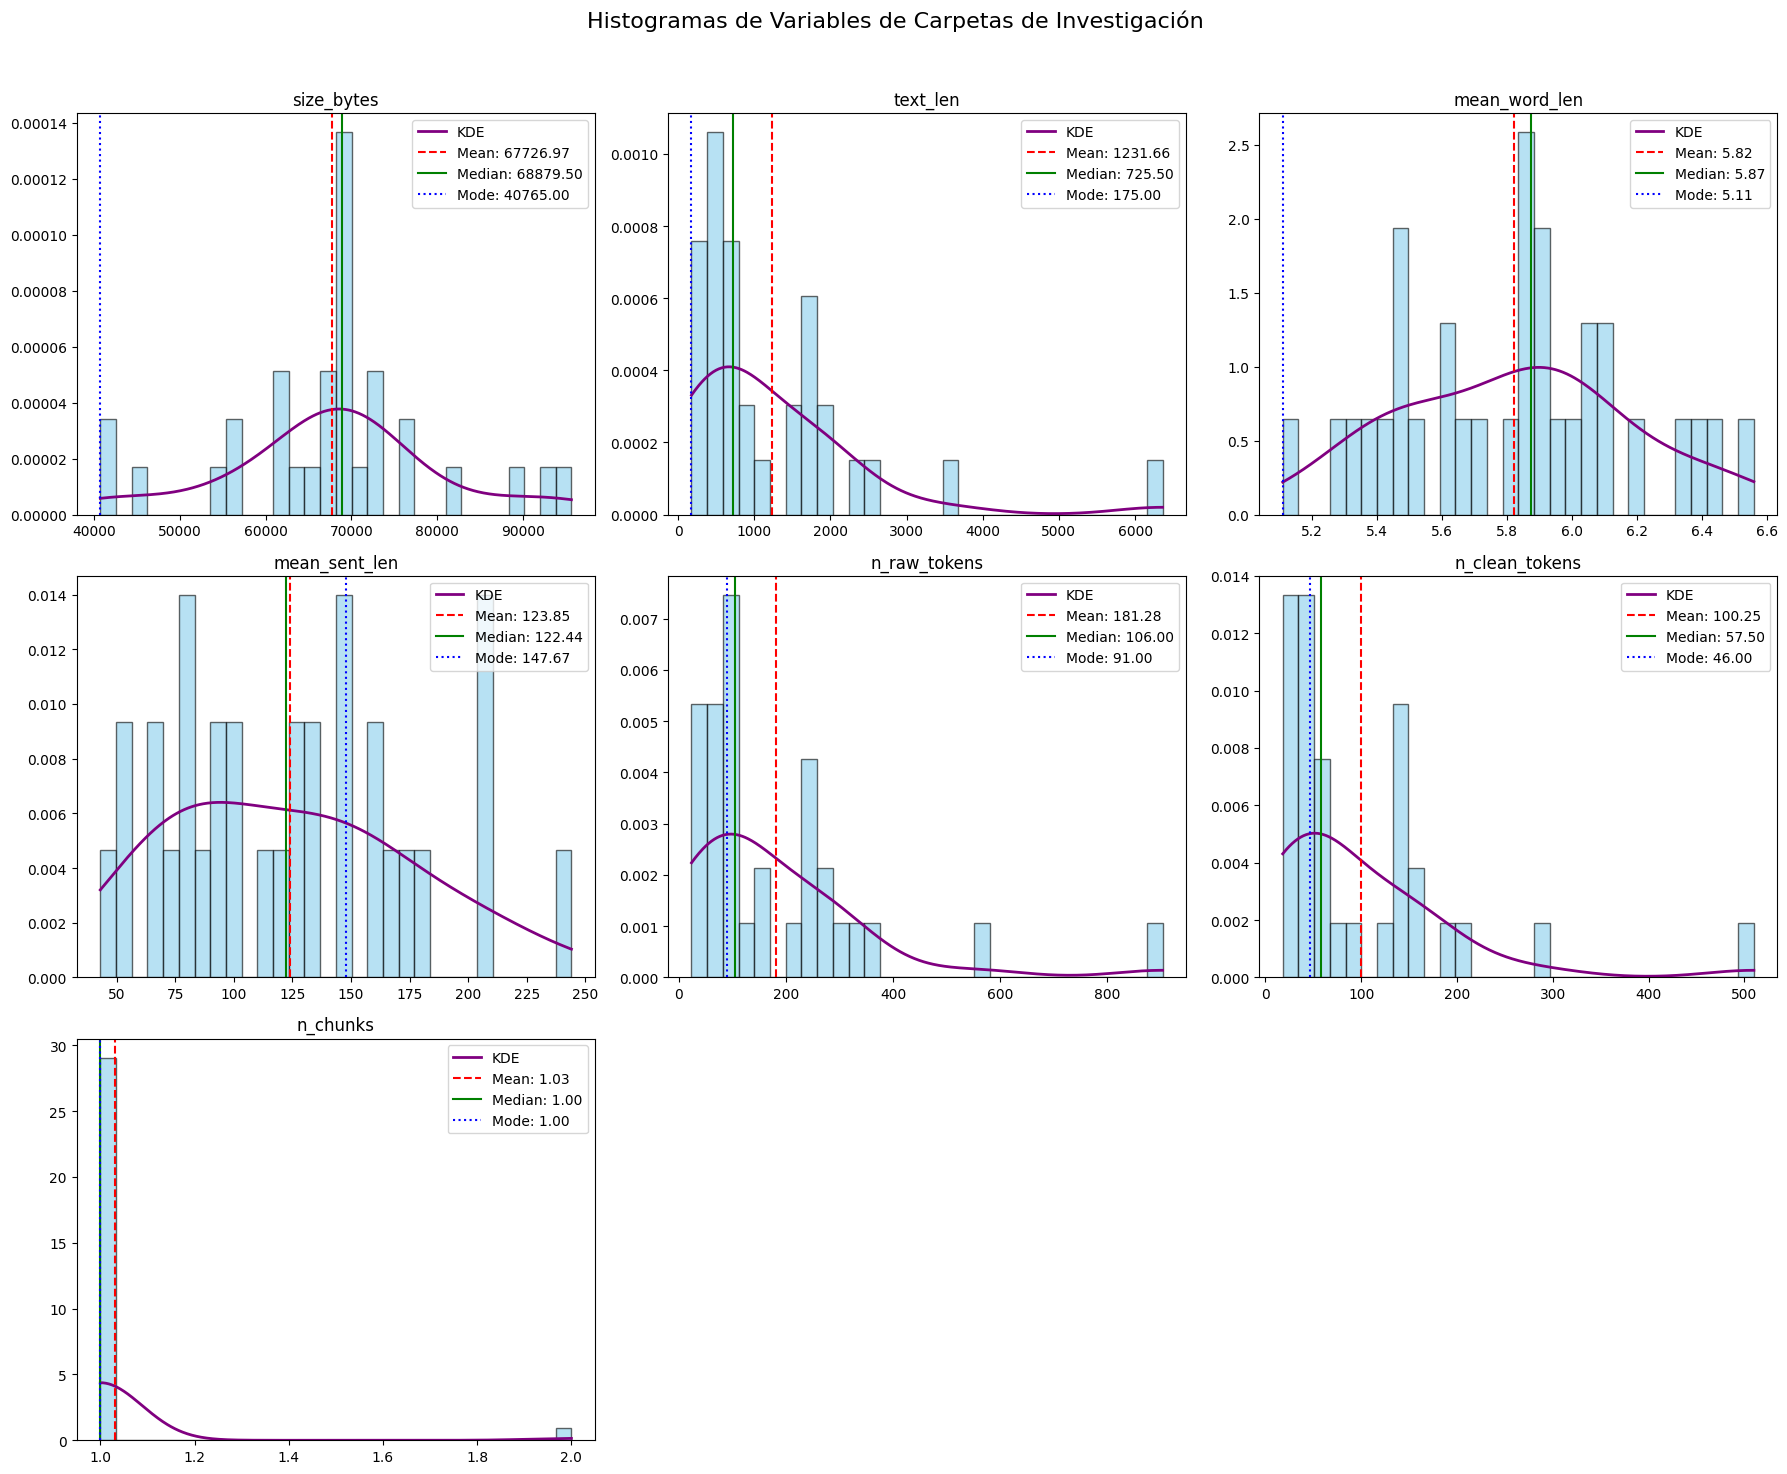

In [27]:
# Histogramas de Variables de Carpetas de Investigación
plot_histograms(carpetas_meta_df, "Histogramas de Variables de Carpetas de Investigación")

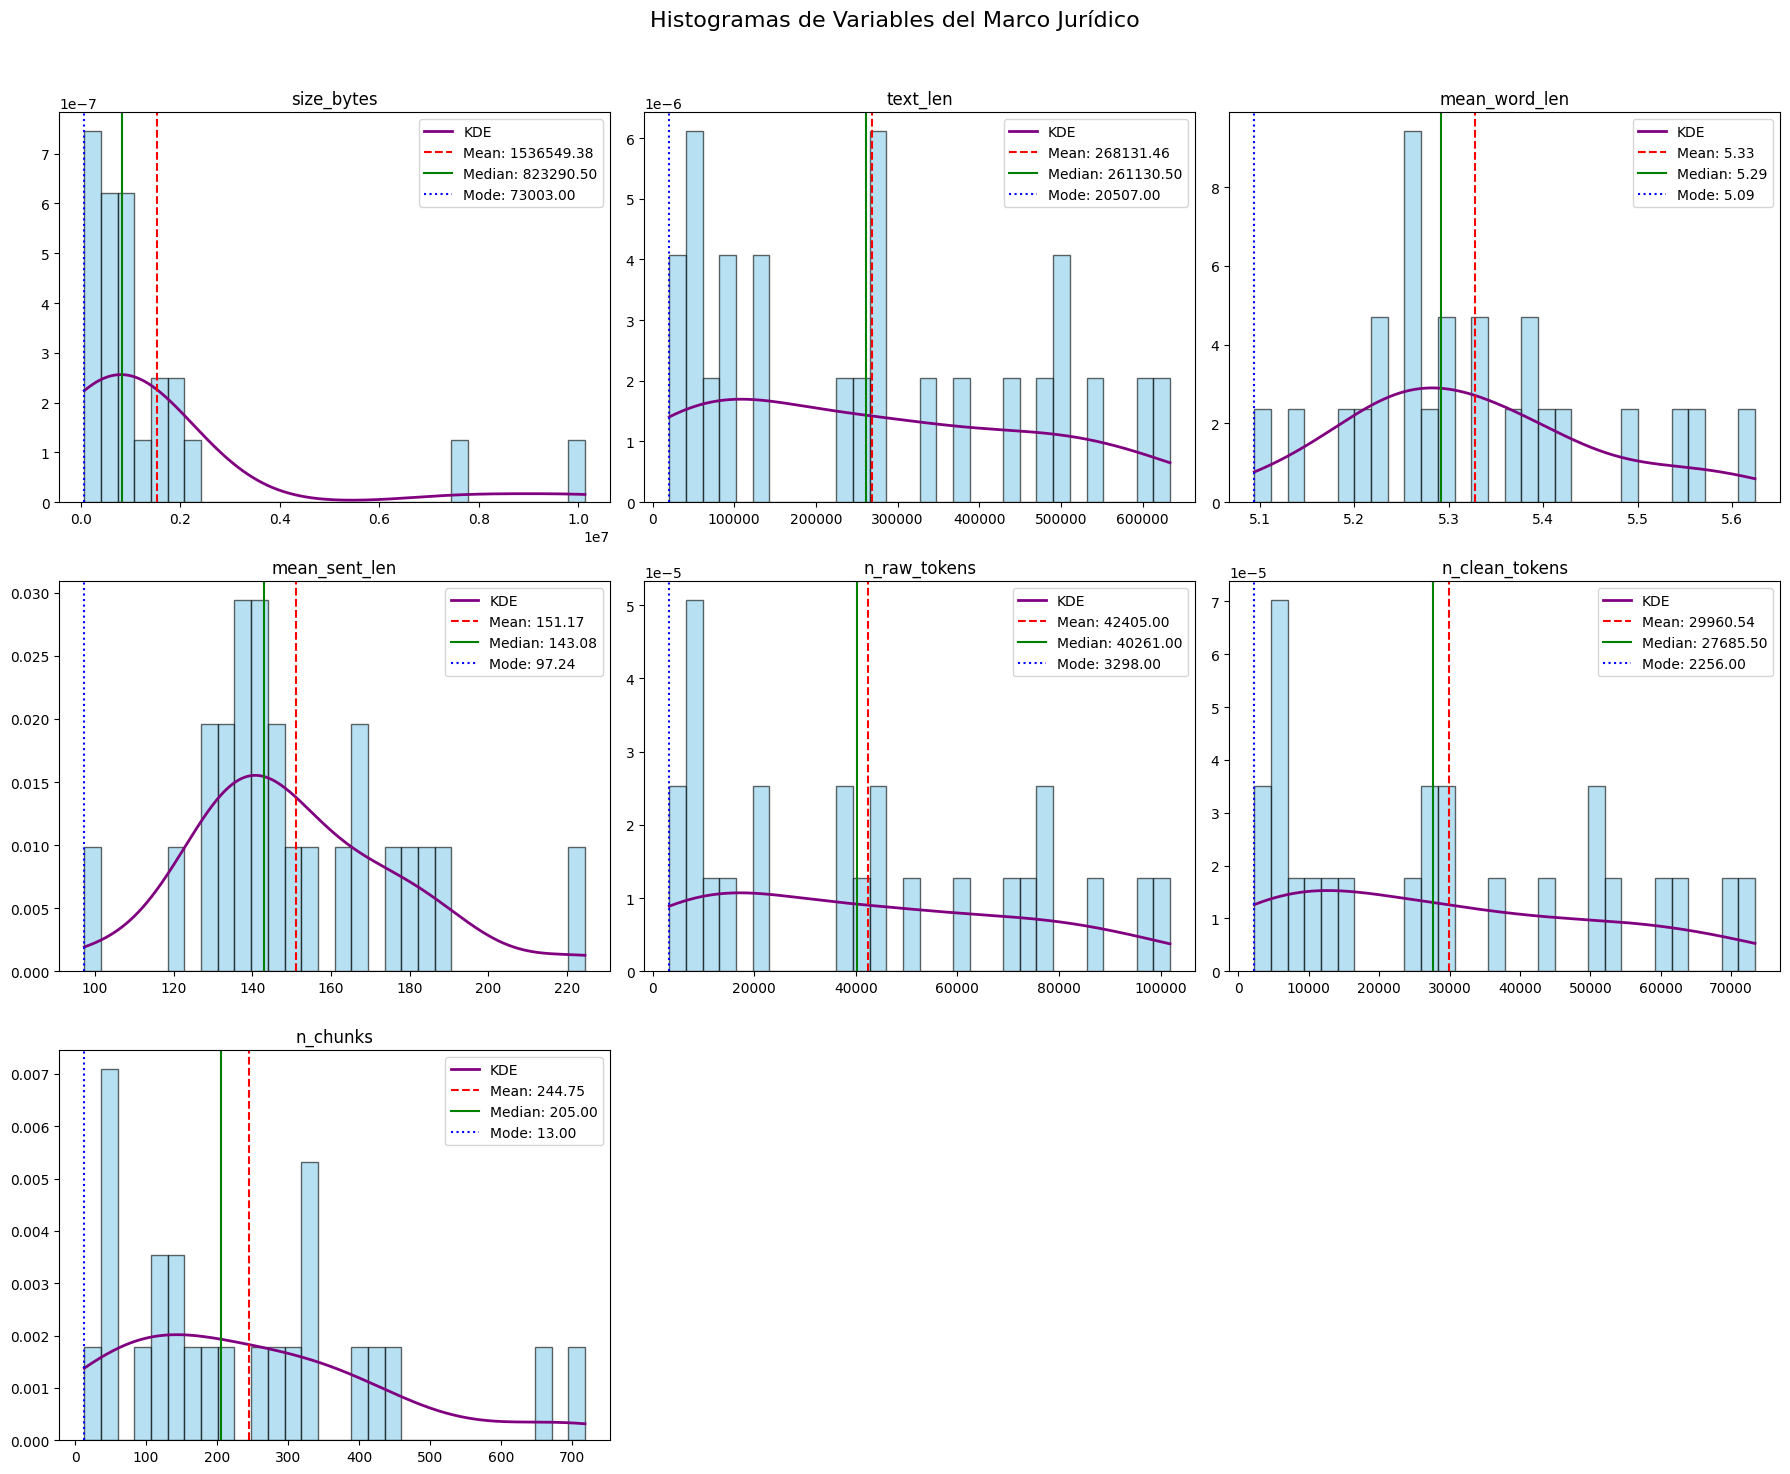

In [28]:
# Histogramas de Variables del Marco Jurídico
plot_histograms(marco_juridico_meta_df, "Histogramas de Variables del Marco Jurídico")

### b) Análisis de distribución

In [29]:
def analyze_distribution(df):
    """
    Analiza la distribución de las columnas numéricas de un DataFrame calculando
    asimetría (skew) y curtosis (kurtosis), y clasificando su tipo.

    Parámetros:
        df (pd.DataFrame) : DataFrame con columnas numéricas. La columna 'name' se excluye.

    Retorno:
        None : La función muestra un DataFrame resumen directamente.
    """

    # 1) Preparación del DataFrame excluyendo 'name'
    df_copy = df.drop(columns=['name']).copy()
    results = {}

    # 2) Iteración sobre cada columna numérica
    for column in df_copy.columns:
        data = df_copy[column].dropna() # Eliminar valores NaN
        skew_val = skew(data)           # Cálculo de asimetría
        kurt_val = kurtosis(data)       # Cálculo de curtosis

        # 3) Clasificación de asimetría
        if skew_val < -0.5:
            skew_type = 'Asimetría negativa'
        elif skew_val > 0.5:
            skew_type = 'Asimetría positiva'
        else:
            skew_type = 'Aproximadamente simétrica'

        # 4) Clasificación de curtosis
        if kurt_val < -1:
            kurt_type = 'Platicúrtica (plana)'
        elif kurt_val > 1:
            kurt_type = 'Leptocúrtica (picuda)'
        else:
            kurt_type = 'Mesocúrtica (normal)'

        # 5) Almacenamiento de resultados
        results[column] = {
            'skew': round(skew_val, 3),
            'skew_type': skew_type,
            'kurtosis': round(kurt_val, 3),
            'kurtosis_type': kurt_type
        }

    # 6) Creación de DataFrame resumen y visualización
    results_df = pd.DataFrame(results).T
    display(results_df)

In [30]:
# Análisis de asimetría y curtosis para Carpetas de Investigación

# 1) Título del análisis
print(f"=== Análisis de Asimetría (Skewness) y Curtosis (Kurtosis) para Carpetas de Investigación ===")

# 2) Ejecución de la función de análisis de distribución
analyze_distribution(carpetas_meta_df)

=== Análisis de Asimetría (Skewness) y Curtosis (Kurtosis) para Carpetas de Investigación ===


,skew,skew_type,kurtosis,kurtosis_type
size_bytes,-0.037,Aproximadamente simétrica,0.603,Mesocúrtica (normal)
text_len,2.514,Asimetría positiva,7.66,Leptocúrtica (picuda)
mean_word_len,0.104,Aproximadamente simétrica,-0.614,Mesocúrtica (normal)
mean_sent_len,0.407,Aproximadamente simétrica,-0.647,Mesocúrtica (normal)
n_raw_tokens,2.368,Asimetría positiva,6.631,Leptocúrtica (picuda)
n_clean_tokens,2.396,Asimetría positiva,6.911,Leptocúrtica (picuda)
n_chunks,5.388,Asimetría positiva,27.032,Leptocúrtica (picuda)


In [31]:
# Análisis de asimetría y curtosis para el Marco Jurídico

# 1) Título del análisis
print(f"=== Análisis de Asimetría (Skewness) y Curtosis (Kurtosis) para el Marco Jurídico ===")

# 2) Ejecución de la función de análisis de distribución
analyze_distribution(marco_juridico_meta_df)

=== Análisis de Asimetría (Skewness) y Curtosis (Kurtosis) para el Marco Jurídico ===


,skew,skew_type,kurtosis,kurtosis_type
size_bytes,2.77,Asimetría positiva,6.662,Leptocúrtica (picuda)
text_len,0.357,Aproximadamente simétrica,-1.211,Platicúrtica (plana)
mean_word_len,0.544,Asimetría positiva,-0.262,Mesocúrtica (normal)
mean_sent_len,0.704,Asimetría positiva,0.798,Mesocúrtica (normal)
n_raw_tokens,0.384,Aproximadamente simétrica,-1.146,Platicúrtica (plana)
n_clean_tokens,0.449,Aproximadamente simétrica,-1.102,Platicúrtica (plana)
n_chunks,0.944,Asimetría positiva,0.327,Mesocúrtica (normal)


### c) Análisis de valores atípicos

In [32]:
def count_outliers(df):
    """
    Cuenta los valores atípicos (outliers) en cada columna numérica de un DataFrame,
    utilizando el criterio del rango intercuartílico (IQR).
    Muestra un DataFrame con el conteo de outliers por columna.

    Parámetros:
        df (pd.DataFrame) : DataFrame con datos. La columna 'name' se excluye automáticamente.

    Retorno:
        None : La función no regresa nada, únicamente muestra el DataFrame con resultados.
    """

    # 1) Preparación del DataFrame excluyendo la columna 'name'
    df_copy = df.drop(columns=['name'], errors='ignore').copy()

    outlier_counts = {}

    # 2) Iteración sobre cada columna para calcular outliers
    for column in df_copy.columns:
        data = df_copy[column].dropna()
        if data.empty:
            outlier_counts[column] = 0
            continue

        # 2a) Cálculo de cuartiles e IQR
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # 2b) Conteo de valores fuera de los límites
        outlier_mask = (data < lower_bound) | (data > upper_bound)
        outlier_counts[column] = outlier_mask.sum()

    # 3) Creación del DataFrame de resultados
    result_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outlier_Count'])

    # 4) Visualización del DataFrame de outliers
    display(result_df)

In [33]:
# Análisis de valores atípicos para Carpetas de Investigación

# 1) Título del análisis
print(f"=== Análisis de Valores Atípicos para Carpetas de Investigación ===")

# 2) Ejecución de la función de conteo de outliers
count_outliers(carpetas_meta_df)

=== Análisis de Valores Atípicos para Carpetas de Investigación ===


,Column,Outlier_Count
0,size_bytes,6
1,text_len,1
2,mean_word_len,0
3,mean_sent_len,0
4,n_raw_tokens,2
5,n_clean_tokens,1
6,n_chunks,1


In [34]:
# Análisis de valores atípicos para el Marco Jurídico

# 1) Título del análisis
print(f"=== Análisis de Valores Atípicos para el Marco Jurídico ===")

# 2) Ejecución de la función de conteo de outliers
count_outliers(marco_juridico_meta_df)

=== Análisis de Valores Atípicos para el Marco Jurídico ===


,Column,Outlier_Count
0,size_bytes,2
1,text_len,0
2,mean_word_len,1
3,mean_sent_len,1
4,n_raw_tokens,0
5,n_clean_tokens,0
6,n_chunks,2


### d) Boxplots

In [35]:
def plot_boxplots(df, title=None):
    """
    Genera boxplots para todas las columnas numéricas de un DataFrame, permitiendo
    identificar visualmente la distribución y posibles outliers.

    Parámetros:
        df (pd.DataFrame) : DataFrame con columnas numéricas. La columna 'name' se excluye.
        title (str, opcional) : Título general del gráfico.

    Retorno:
        None : La función muestra los boxplots directamente.
    """

    # 1) Preparación del DataFrame excluyendo 'name'
    df_copy = df.drop(columns=['name']).copy()
    num_cols = len(df_copy.columns)
    rows = math.ceil(math.sqrt(num_cols))
    cols = math.ceil(num_cols / rows)

    # 2) Creación de la figura y los ejes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()

    # 3) Iteración sobre cada columna para generar boxplots
    for i, column in enumerate(df_copy.columns):
        data = df_copy[column].dropna()  # Eliminar NaN
        axes[i].boxplot(data, vert=True, patch_artist=True, boxprops=dict(facecolor='skyblue'))
        axes[i].set_title(f'{column}')

    # 4) Eliminación de ejes vacíos si hay más subplots que columnas
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 5) Título general si se proporciona
    if title:
        fig.suptitle(title, fontsize=16)

    # 6) Ajuste de layout y visualización
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

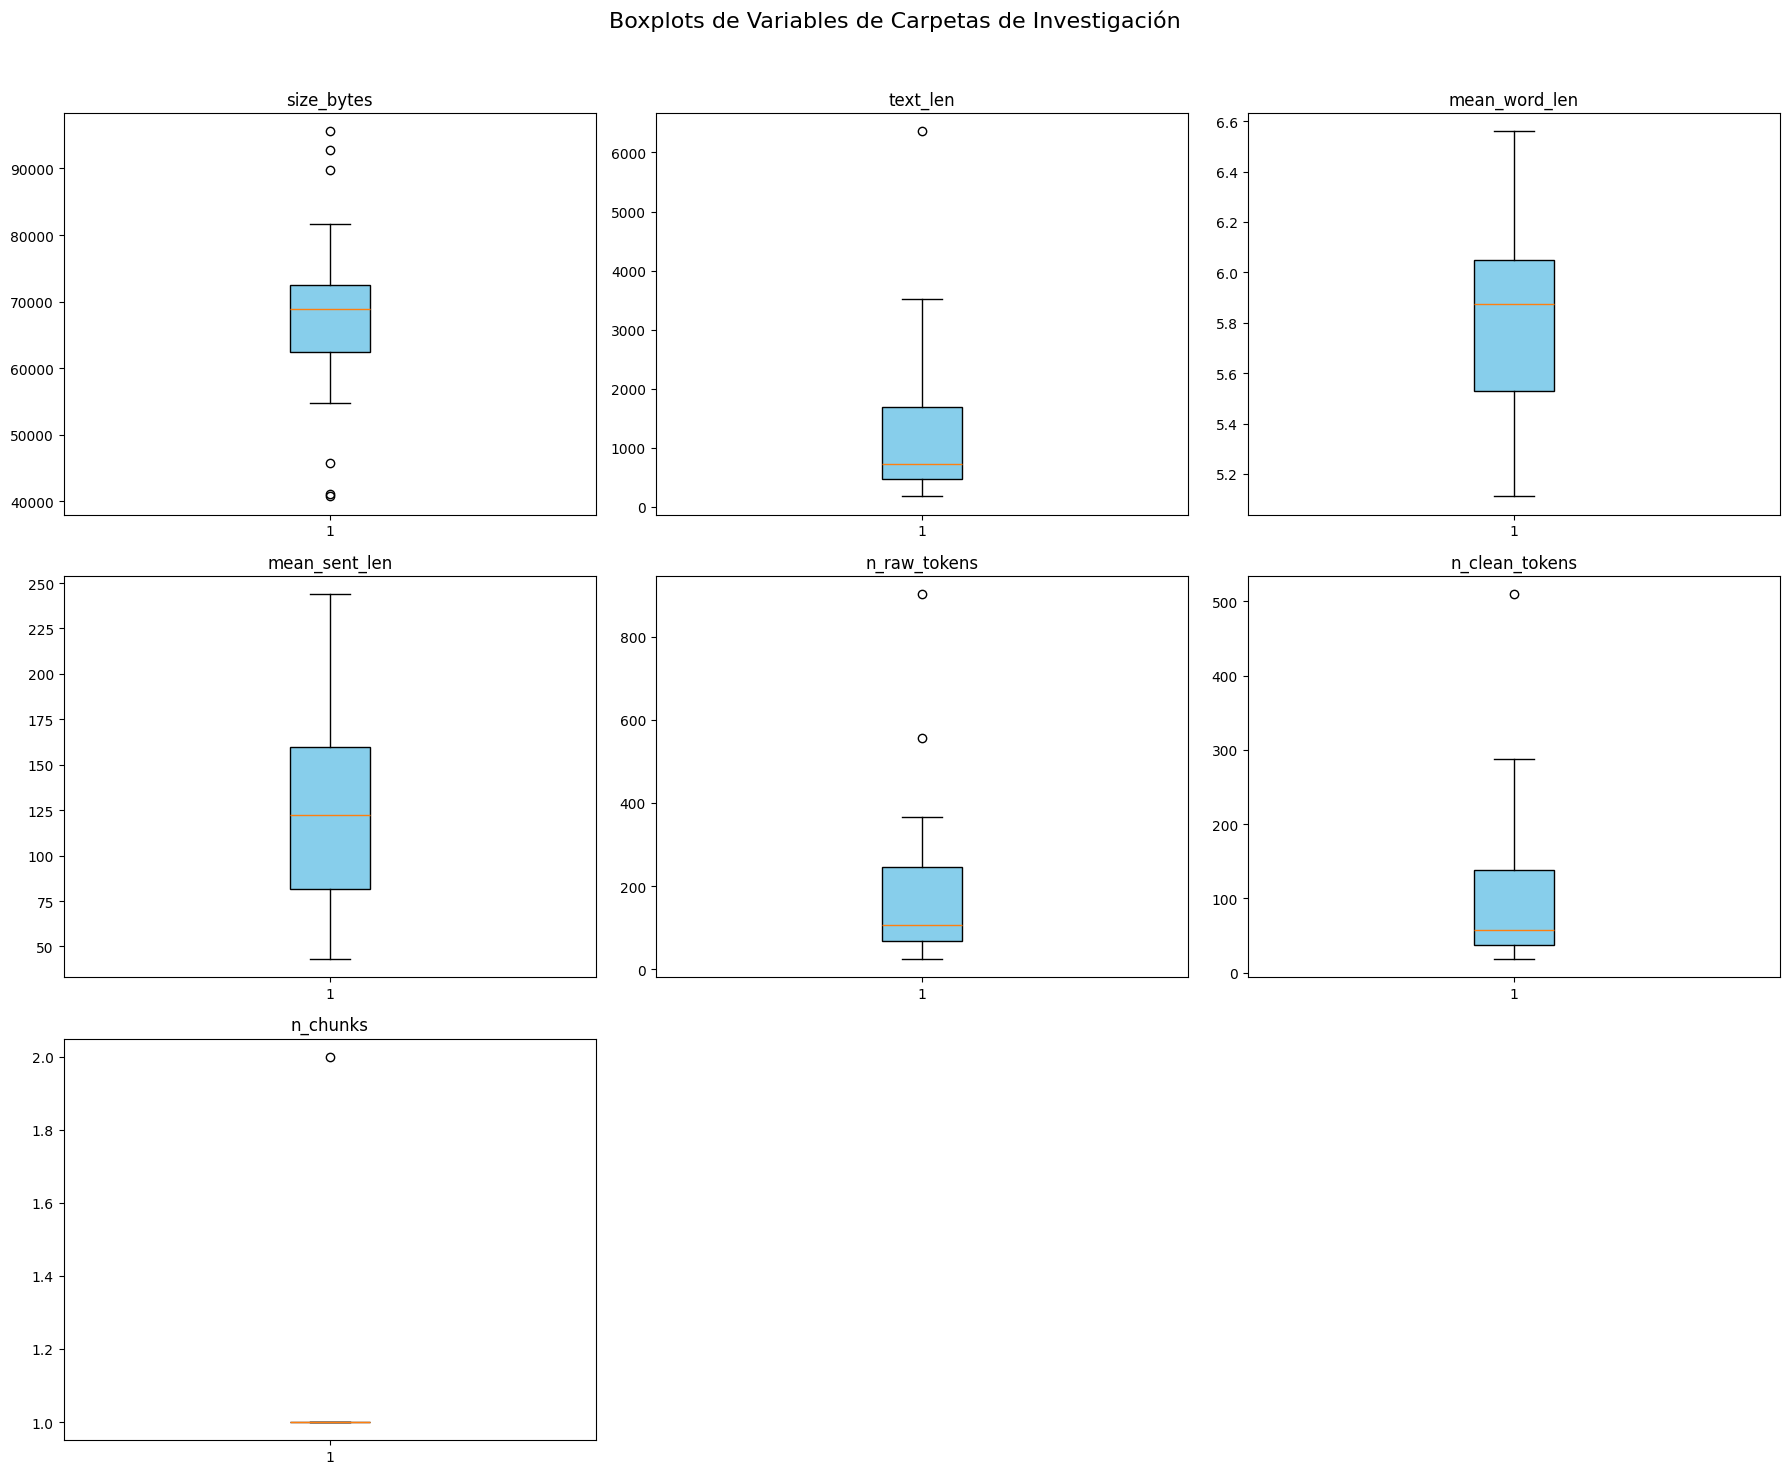

In [36]:
# Boxplots de Variables de Carpetas de Investigación
plot_boxplots(carpetas_meta_df, "Boxplots de Variables de Carpetas de Investigación")

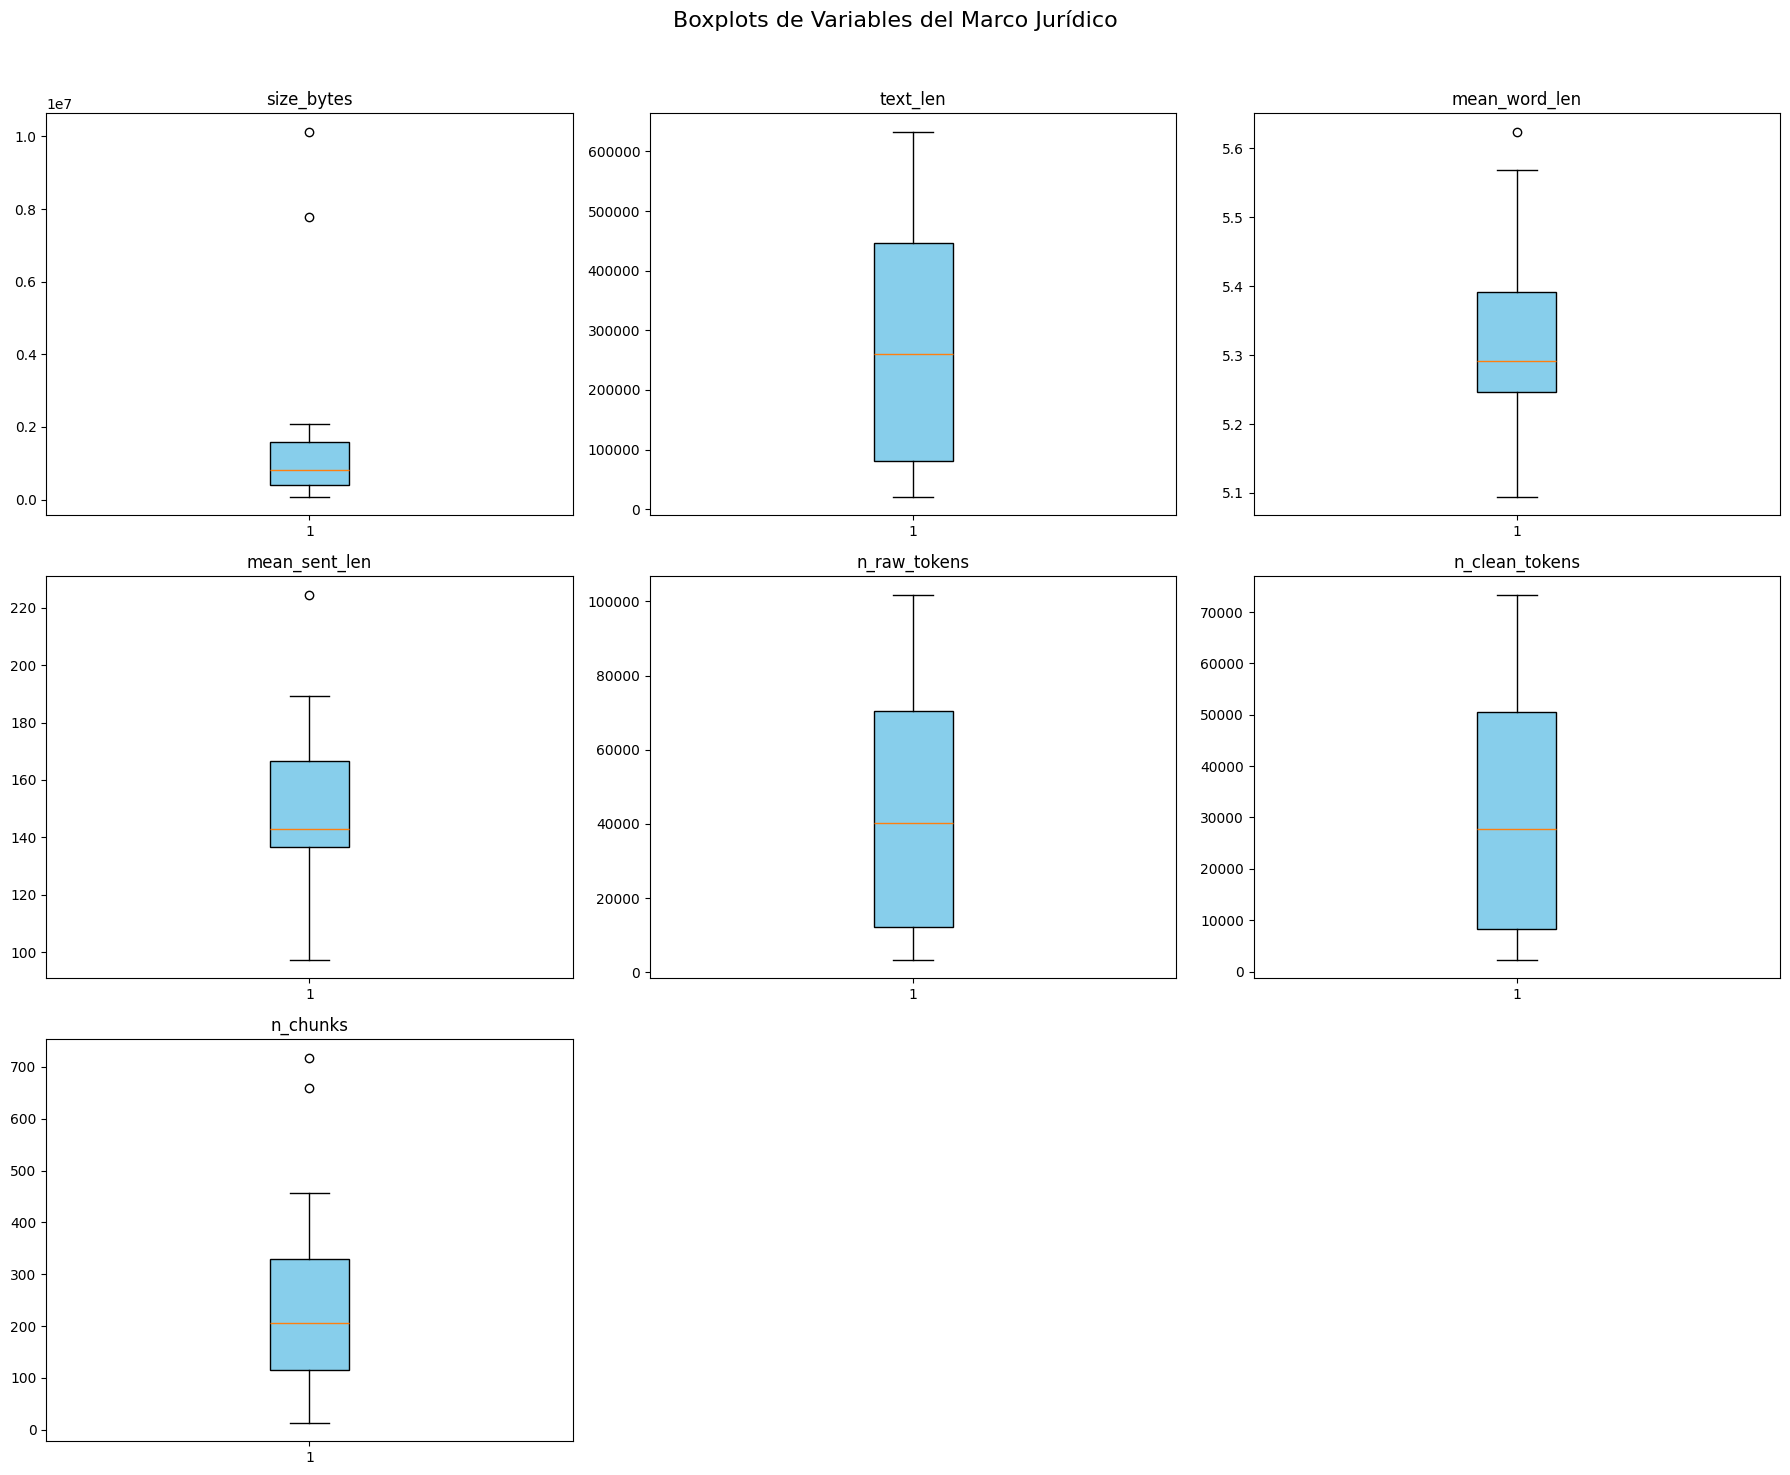

In [37]:
# Boxplots de Variables del Marco Jurídico
plot_boxplots(marco_juridico_meta_df, "Boxplots de Variables del Marco Jurídico")

## 4.3. Análisis bivariante

### a) Scatter plots

In [38]:
def plot_comparative_scatter(df, target_column, title=None):
    """
    Crea gráficos de dispersión comparativos de cada columna numérica frente a una
    columna dependiente, coloreando por quartiles de la variable dependiente.

    Parámetros:
        df (pd.DataFrame) : DataFrame con los datos.
        target_column (str) : Nombre de la columna dependiente (variable Y).
        title (str, opcional) : Título general de la figura.

    Retorno:
        None : La función muestra los gráficos de dispersión directamente.
    """

    # 1) Preparación del DataFrame excluyendo 'name' y validación de columna dependiente
    df_copy = df.drop(columns=['name'], errors='ignore').copy()
    if target_column not in df_copy.columns:
        raise ValueError(f"La columna dependiente '{target_column}' no existe en el DataFrame")

    df_copy = df_copy.drop(columns=[target_column])
    num_cols = len(df_copy.columns)
    rows = math.ceil(math.sqrt(num_cols))
    cols = math.ceil(num_cols / rows)

    # 2) Creación de la figura y los ejes
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 6, rows * 5))
    axes = axes.flatten()

    # 3) Iteración sobre cada columna para generar scatter plots comparativos
    for i, column in enumerate(df_copy.columns):
        x_data = df_copy[column].dropna()
        y_data = df[target_column].reindex(x_data.index)  # Alineación de índices

        # 3a) Colorear puntos según quartiles de la variable dependiente
        quartiles = np.quantile(y_data, [0, 0.25, 0.5, 0.75, 1])
        colors = ['skyblue', 'lightgreen', 'orange', 'pink']

        for j in range(len(quartiles)-1):
            mask = (y_data >= quartiles[j]) & (y_data <= quartiles[j+1])
            axes[i].scatter(x_data[mask], y_data[mask], color=colors[j], alpha=0.6, label=f'Y in Q{j+1}')

        # 3b) Etiquetas y título del gráfico
        axes[i].set_xlabel(column)
        axes[i].set_ylabel(target_column)
        axes[i].set_title(f'{column} vs {target_column}')
        axes[i].legend()

    # 4) Eliminación de ejes vacíos si sobran subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # 5) Título general si se proporciona
    if title:
        fig.suptitle(title, fontsize=16)

    # 6) Ajuste de layout y visualización
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

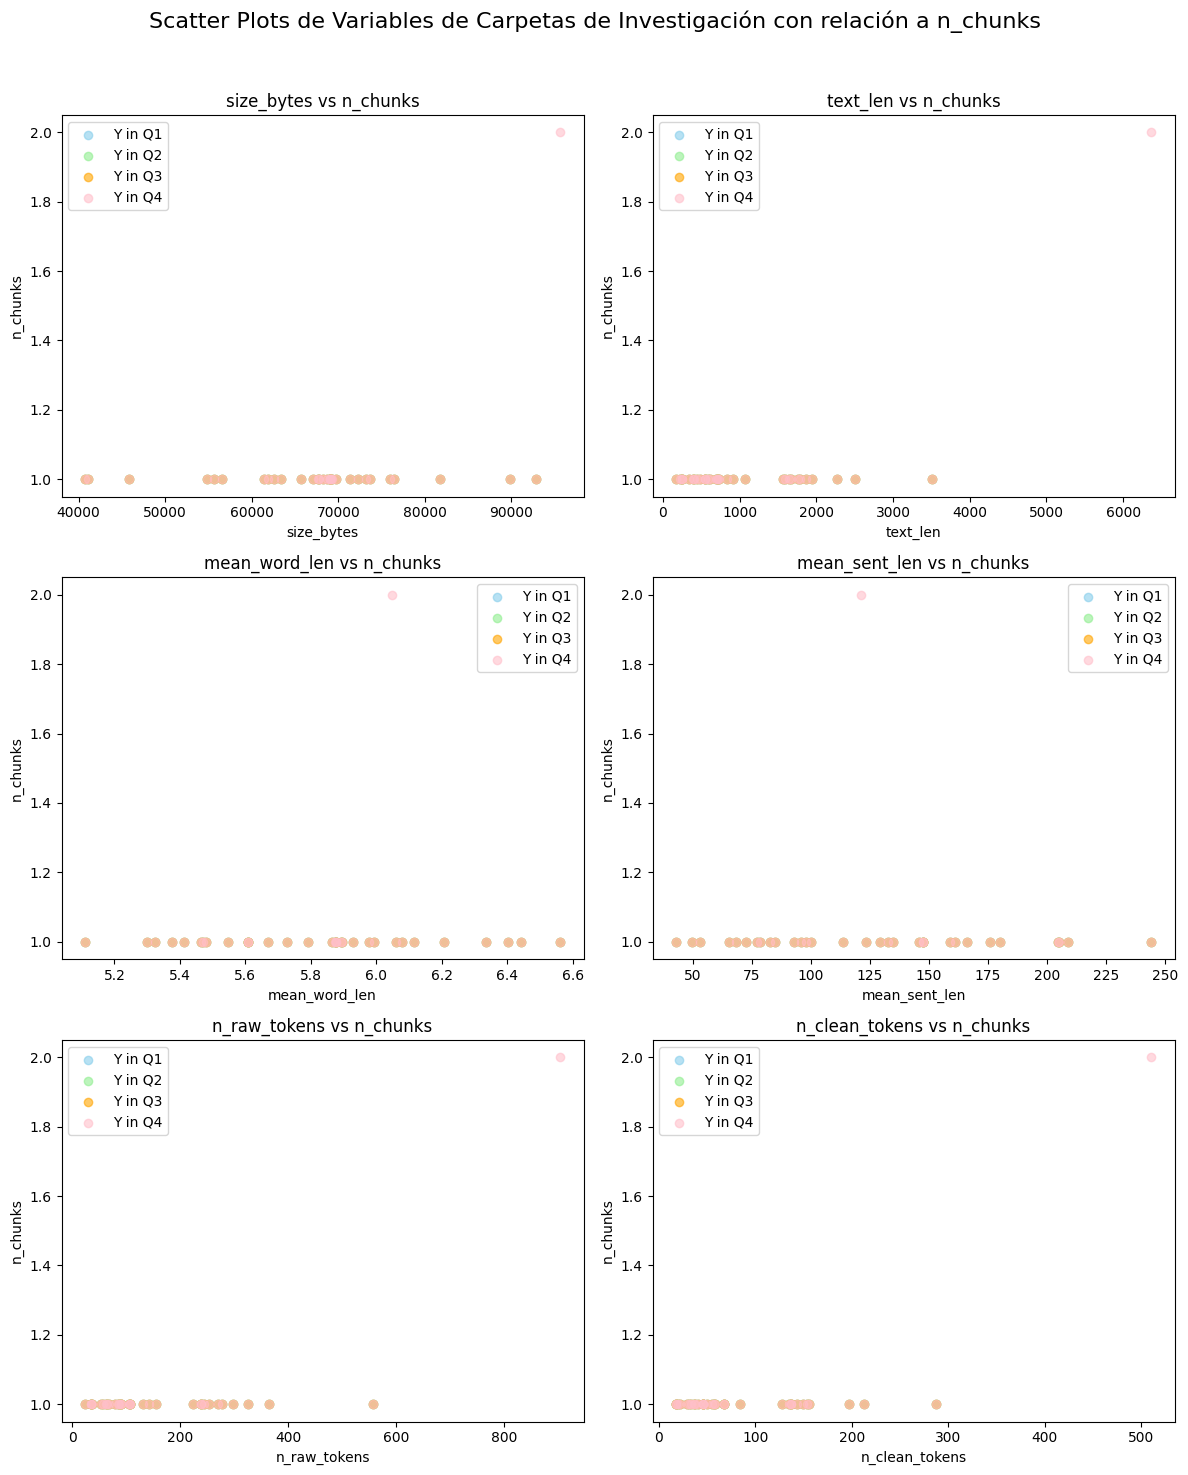

In [39]:
# Scatter plots comparativos de variables de Carpetas de Investigación frente a n_chunks
plot_comparative_scatter(carpetas_meta_df, "n_chunks", "Scatter Plots de Variables de Carpetas de Investigación con relación a n_chunks")

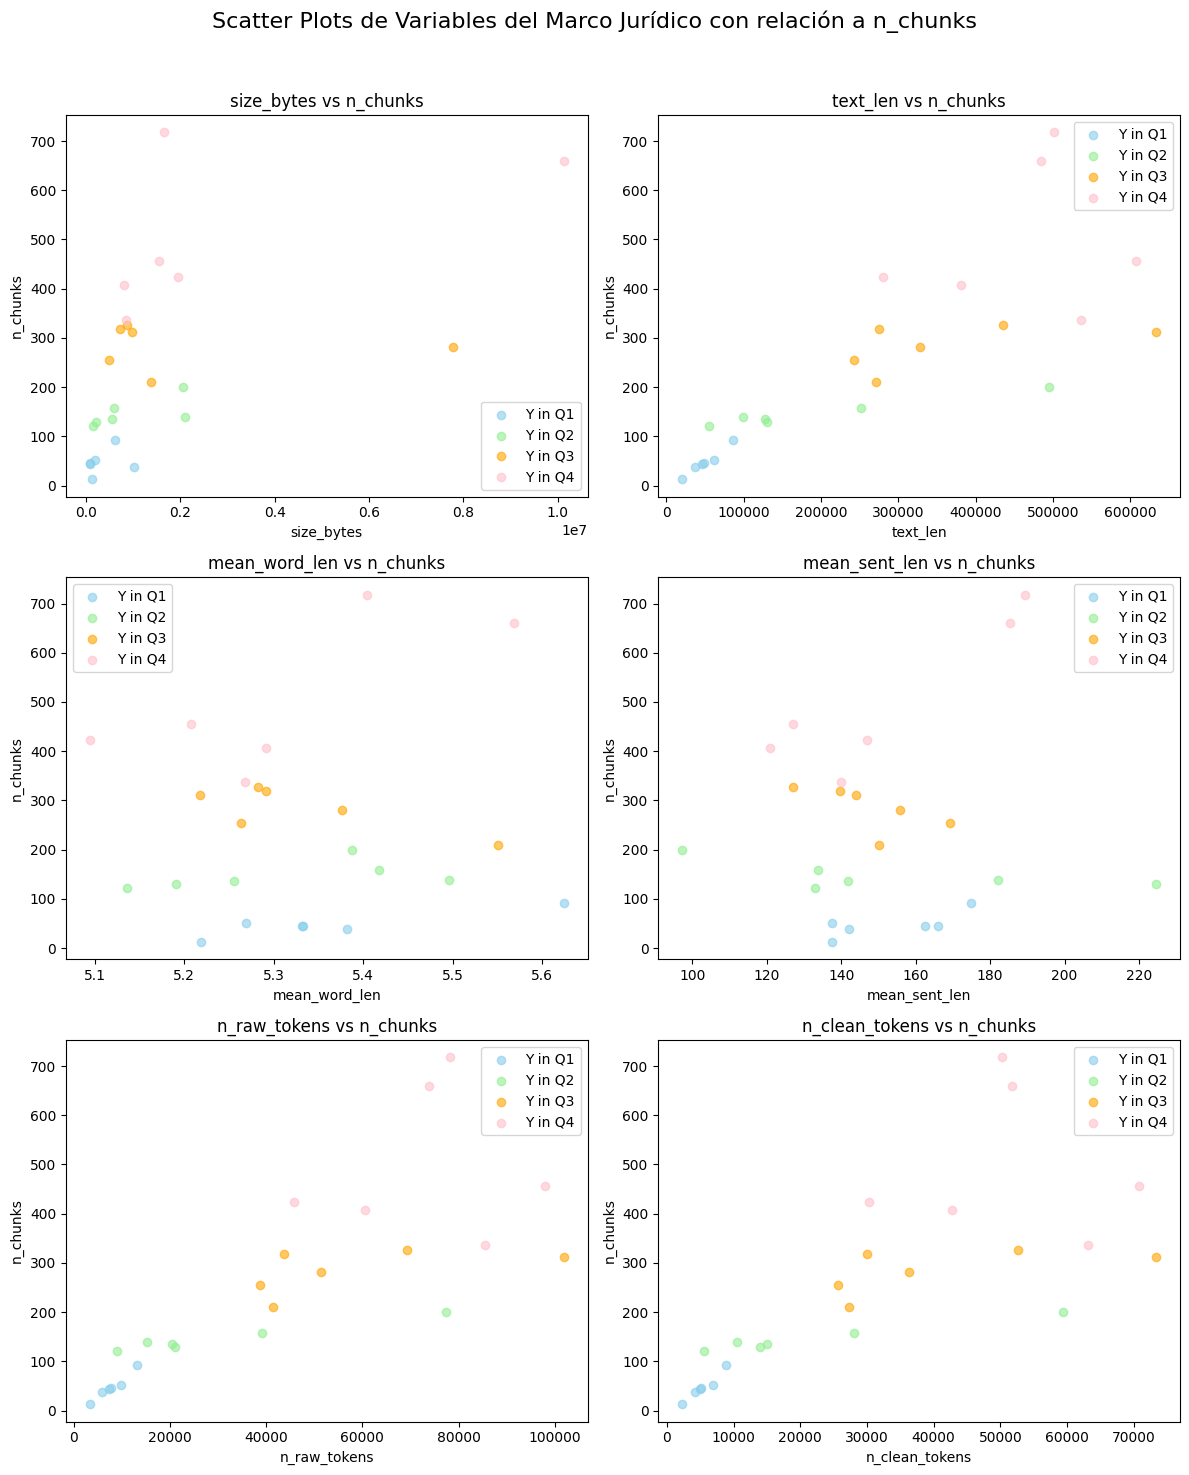

In [40]:
# Scatter plots comparativos de variables del Marco Jurídico frente a n_chunks
plot_comparative_scatter(marco_juridico_meta_df, "n_chunks", "Scatter Plots de Variables del Marco Jurídico con relación a n_chunks")

### b) Correlaciones

In [41]:
def plot_correlation(df, title=None, figsize=(10,8)):
    """
    Genera un mapa de calor de correlación para las columnas numéricas de un DataFrame.

    Parámetros:
        df (pd.DataFrame) : DataFrame con datos numéricos. La columna 'name' se excluye.
        title (str, opcional) : Título del gráfico de correlación.
        figsize (tuple, opcional) : Tamaño de la figura (ancho, alto).

    Retorno:
        None : La función muestra el mapa de calor directamente.
    """

    # 1) Preparación del DataFrame excluyendo 'name'
    df_copy = df.drop(columns=['name'], errors='ignore').copy()

    # 2) Cálculo de la matriz de correlación
    corr_matrix = df_copy.corr()

    # 3) Creación del heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True)

    # 4) Título opcional
    if title:
        plt.title(title, fontsize=16)

    # 5) Ajuste de layout y visualización
    plt.tight_layout()
    plt.show()

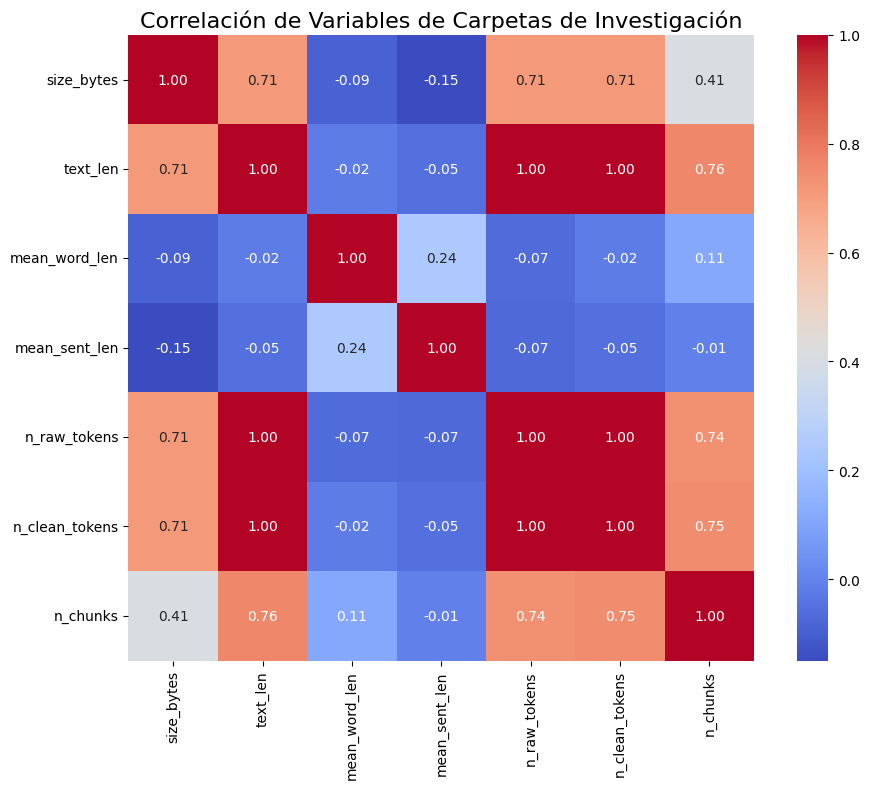

In [42]:
# Mapa de calor de correlación para Carpetas de Investigación
plot_correlation(carpetas_meta_df, "Correlación de Variables de Carpetas de Investigación")

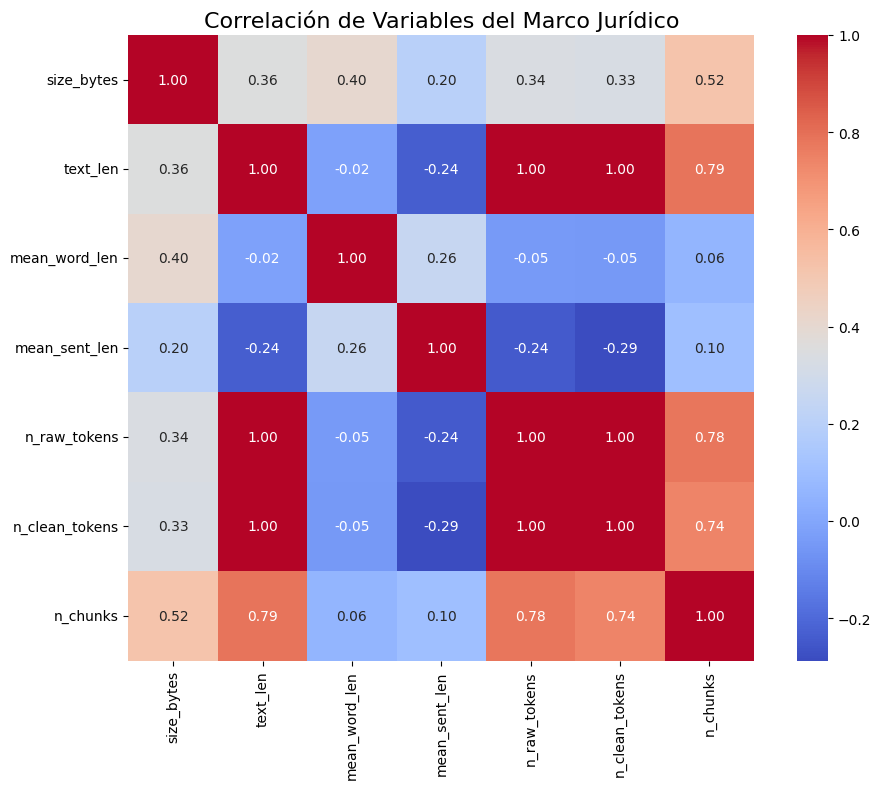

In [43]:
# Mapa de calor de correlación para el Marco Jurídico
plot_correlation(marco_juridico_meta_df, "Correlación de Variables del Marco Jurídico")

# 5. Conclusiones

Los datos provenientes de textos requieren de un Análisis Exploratorio y Preprocesamiento espaciales. Esto último, ya que la estructura y naturaleza de esos datos, difiere de aquellos que representan cifras continuas o discretas, o que son categóricos.

En el presente proyecto se trabaja con datos de texto. Estos datos representan el contenido de documentos, los cuales fueron escritos siguiendo ciertas reglas léxicas, sintácticas, ortográficas, siguiendo una lógica, coherencia y cohesion relativas a materias específicas. Para el caso de este trabajo, dichos documentos representaron textos legales y jurídicos, como leyes, códigos, jurisprudencias, oficios, narraciones de hechos, etc.

En primer lugar, se procedió a la **conformación de un corpus de textos** que representan los datos con lo cuales el proyecto "Chatbot jurídico para soporte informativo en el análisis de Carpetas de Investigación" va a trabajar. Este corpus está integrado por los siguientes tipos de documentos:
	- Documentos legales (**Marco Jurídico**): contienen textos que están divididos estructuralmente siguiendo una lógica jurídica (como capítulos, secciones, artículos, etc.). Provienen de instituciones, entidades y fuentes legales (como Código Penal para el Estado de Michoacán, Ley Orgánica de la Fiscalía General del Estado de Michoacán, etc.).
	- Documentos de **Carpetas de Investigación**: tienen textos escritos siguiendo una narrativa legal o jurídica, o siguiendo formatos administrativo-legales. Se generan dentro de la propia Unidad de la Fiscalía con la que se trabaja en el proyecto.

En segundo lugar, se procedió con el **preprocesamiento** de los datos de los textos. Este proceso es sustancialmente diferente al preprocesamiento de los tipos de datos numéricos o categóricos. Pues, el procesar los textos no se trata de una tarea de buscar valores atípicos, faltantes o imputar cifras, sino que la tarea en realidad es preservar tanto la estructura lógica e integridad semántica de los textos (Ferraris et al., 2024), toda vez que son procesados para que los modelos de *Machine Learning* puedan utilizarlos. Para esta tarea de preprocesamiento se utilizaron técnicas de Procesamiento de Lenguaje Natural o *Natural Language Processing* (*NLP*). Específicamente se aplicaron técnicas de *Chunking* (dividir fragmentos de texto o *tokens* en segmentos) y *Tokenización* (dividir el texto en unidades más pequeñas como palabras, subpalabras o caracteres) (Vaj, 2024).
  - Para Documentos legales (**Marco Jurídico**) se utilizó:
    * ***Tokenización***: se aplicó un proceso de *Tokenización* más fuerte, pues estos documentos no presentan una estructura rígida como la de artículos, sino que presenta textos más narrativos. En este sentido se aplicó un proceso de limpieza del corpus aplicando normalizando Unicode, convirtiendo a minúsculas, filtrando palabras cortas o no alfabéticas y eliminando stopwords en español, con el objetivo de tener *tokens* que representaran patrones clave.
    * **Chunking**: se siguió la técnica desarrollada por el artículo '*No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts*' (Fama et al., 2024). Este artículo procesa textos legales y mostró buenos resultados en su procesamiento de *chunks*. Este a grandes rasgos hace un *overlap* especial que mantiene el contexto de *chunks* pasados en nuevos, evitando la perdida de contexto en textos muy largos.
  - Documentos de **Carpetas de Investigación** se utilizó:
    * ***Tokenización***: estos textos son más rígidos, presentando estructuras por artículos, párrafos, etc. De esta manera, se procedió con una limpieza de texto más simple para que el contexto del contenido no se perdiera, conservando así saltos de línea, divisiones entre párrafos y preservando números y puntuación.
    * ***Chunking***: para esta sección se aplicó un proceso de *Chunking* estructural con un *overlap* mínimo entre segmentos, con el objetivo de preservar artículos completos en los *chunks* y no perder el contexto de estos artículos. Por tal motivo, se aplicaron expresiones regulares para identificar y preservar estas secciones.

Por último, se realizó un Análisis Exploratorio de Datos o *Exploratory Data Analysis* (*EDA*). Este análisis permite desentrañar la naturaleza intrínseca de los datos, caracterizar sus principales atributos y descubrir las interrelaciones entre variables (Ministerio de Asuntos Económicos y Transformación Digital, 2024). Existen métodos de *EDA* específicos que funcionan para problemas de *NLP* (como es el caso de este proyecto) y que conducen a un resultado productivo. Para esto normalmente se utilizan recuentos de palabras y oraciones, su longitud y longitud promedio (Singh, 2022). En este trabajo se utilizaron las siguientes métricas:
  - `size_bytes`: tamaño físico del archivo en bytes.
  - `text_len`: longitud total del texto extraído del documento, medida en número de caracteres.
  - `mean_word_len`: largo promedio de las palabras en el documento, medida en caracteres.
  - `mean_sent_len`: largo promedio de las oraciones en el documento, medida en caracteres.
  - `n_raw_tokens`: número total de tokens crudos que resultan de una división simple del texto por espacios.
  - `n_clean_tokens`: número total de tokens limpios después de aplicar el proceso de *Tokenización* correspondiente.
  - `n_chunks`: número total de *chunks* en los que se dividió el texto después de aplicar el proceso de *Chunking* correspondiente.

Los resultados del *EDA* fueron los siguientes:
  - Los documentos de las Carpetas de Investigación son más pequeños y presentan menos texto que los documentos del Marco Jurídico.
  - Con los procesos de *Tokenización* y *Chunking* aplicados, se puede observar que cada documento de las Carpetas de Investigación pueden estar contenido en un solo *chunk*, con excepción de las narraciones de hechos (que son documentos muy importantes y usualmente más largos). Para los documentos del Marco Jurídico, se produjeron más *chunks*, esto asegura que estructuras como artículos se guarden completos en un *chunk* preservando contexto.
  - Las métricas de las Carpetas de Investigación muestran distribuciones asimétricas positivas y leptocúrticas en `text_len`, `n_raw_tokens`, `n_clean_tokens` y `n_chunks`, indicando documentos uniformes con valores extremos. En contraste, el Marco Jurídico presenta distribuciones variadas, con asimetría positiva o simétrica y curvas leptocúrticas, mesocúrticas o platicúrticas, reflejando mayor heterogeneidad. Esto implica que los documentos de Carpetas de Investigación son más consistentes en longitud y complejidad, mientras que los del Marco Jurídico requieren preprocesamiento en *NLP* más flexible debido a su diversidad (tal como se consideró en su *Tokenización*).
  - En el análisis de valores atípicos en las métricas, para las Carpetas de Investigación, se puede observar ciertos *outliers* en `text_len` o `n_raw_tokens`, por lo que se infiere que ciertos documentos llegan a tener un poco más de texto que los otros, en especial la narración de hechos (que es un documento muy importante). Para el Marco Jurídico, hay ciertos *outliers* en *n_chunks* lo cual se puede inferir en cómo se maneja el *Chunking*, guardando estructuras como artículos, sin importar su longitud.
  - En el análisis bivariante, tomando como variable dependiente a `n_chunks`, se puede observar que para las Carpetas de Investigación por la forma del *Chunking* que establece un proceso más constante en su tamaño, muestra que mientras más texto tenga un documento, este no produce muchos más *chunks*. Para el Marco Jurídico, parece ser que mientras más texto tiene un documento, más *chunks* puede producir, así mientras más largo el documento, más estructuras tiende a tener (como artículos).
  - En cuanto a la correlación de métricas, para ambos tipos de documentos `text_len`, `n_raw_tokens`, `n_clean_tokens` y `n_chunks` presentan número altos, indicando que un mayor volumen de texto corresponde directamente a un aumento en el número de *tokens* y *chunks*, independientemente del proceso de *Tokenización* y *Chunking* aplicados.

En conclusion, el presente trabajo dió como resultado un análisis completo de la estructura y contenido de los documentos tanto de las Carpetas de Investigación, como del Marco Jurídico. Se formó un corpus de texto y se aplicaron técnicas de *NLP* siguiendo la lógica de su contenido y técnicas encontradas en la literatura. Por su parte el análisis *EDA*, mostró cómo los documentos del Marco Jurídico presentan mayor cantidad de texto y variabilidad de volumen de texto, lo que sugiere que técnicas de *NLP* más flexibles como las aplicadas, pueden ser las correctas para conservar esa variabilidad y no perder contexto. Por su parte, los documentos de las Carpetas de Investigación, presentan menos texto y menos variabilidad en volumen, lo que sugiere que aplicar técnicas de *NLP* más rigurosas puede ayudar a optimizar la segmentación, analizar e identificar partes importantes, y asegurar precisión en la extracción de patrones clave, especialmente en documentos críticos como las narraciones de hechos.

# 6. Referencias

- Fama, I., Bueno, B., Alcoforado, A., Ferraz, T. P., Moya, A., & Costa, A. H. R. (2024). No Argument Left Behind: Overlapping Chunks for Faster Processing of Arbitrarily Long Legal Texts. *arXiv*. https://arxiv.org/abs/2410.19184.

- Ferraris, A. F., Audrito, D., Siragusa, G., & Piovano, A. (2024). Legal Chunking: Evaluating Methods for Effective Legal Text Retrieval. En J. Savelka et al. (Eds.), *Legal Knowledge and Information Systems* (pp. 275-281). IOS Press. https://doi.org/10.3233/FAIA241255.

- Ministerio de Asuntos Económicos y Transformación Digital. (2024). *A Practical Guide to Introduce Exploratory Data Analysis with Python*. datos.gob.es. https://datos.gob.es/sites/default/files/doc/file/guide_eda_python.pdf.

- Panda, B., Panigrahi, C., & Pati, B. (2022). Exploratory Data Analysis and Sentiment Analysis of Drug Reviews. *Computación y Sistemas*, *26*(3). https://doi.org/10.13053/cys-26-3-4093.

- Singh, H. (2022, 27 de Septiembre). Complete Guide to EDA on Text Data. *Kaggle*. https://www.kaggle.com/code/harshsingh2209/complete-guide-to-eda-on-text-data/input.

- Vaj, T. (2024, 25 de Septiembre). Chunking vs tokenization. *Medium*. https://vtiya.medium.com/chucking-vs-tokenization-4805d8099885.